<a href="https://colab.research.google.com/github/rodezi/EntregableBEDU_Machine_Learning/blob/main/Entregable_Bedu_Modelo_de_Machine_Learning_Rodrigo_Zayas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Prediccion de cancer Pulmonar**

1. En este proyecto, vamos a plantearnos las siguientes preguntas:
¿Podemos predecir si una persona tiene cáncer de pulmón (y qué tipo: benigno, maligno o ninguno) con base en sus síntomas y datos demográficos?

**Objetivo:** Desarrollar un modelo de aprendizaje supervisado que, dada una combinación de síntomas, edad y género, pueda predecir con precisión el tipo de cáncer que tiene un paciente.

**Variable objetivo:** `LUNG_CANCER` (0: No cancer, 1: Benigno, 2: Maligno)

**Tipo de modelo:** Clasificación multiclase.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("khwaishsaxena/lung-cancer-dataset")

print("Path to dataset files:", path)

100%|██████████| 18.3M/18.3M [00:01<00:00, 13.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/khwaishsaxena/lung-cancer-dataset/versions/1


## 2. Carga de Datos

Se usará el dataset "Lung Cancer Dataset" proveniente de Kaggle. Este conjunto contiene registros médicos de pacientes junto con síntomas y diagnóstico final sobre la presencia de cáncer de pulmón.

El dataset se descargó usando `kagglehub`, una herramienta que permite acceder directamente a datasets desde notebooks en Google Colab.

En esta sección cargamos el archivo CSV y mostramos las primeras filas para tener una idea general de los datos disponibles.

In [2]:
import numpy as np
import pandas as pd

In [7]:
df = pd.read_csv("Lung Cancer.csv")
df.head()

,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199.0,0.0,0.0,1.0,0.0,Chemotherapy,2017-09-10,0.0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280.0,1.0,1.0,0.0,0.0,Surgery,2024-06-17,1.0
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268.0,1.0,1.0,0.0,0.0,Combined,2024-04-09,0.0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241.0,1.0,1.0,0.0,0.0,Chemotherapy,2017-04-23,0.0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178.0,0.0,0.0,0.0,0.0,Combined,2025-01-08,0.0


## 3. Limpieza y Exploración de Datos

Antes de aplicar cualquier modelo, es fundamental entender y limpiar los datos:

- **Información general:** Revisamos el número de filas, tipos de datos, y valores nulos.
- **Exploración de columnas:** Verificamos la coherencia en las categorías (por ejemplo, si hay valores como "Male", "male", "M").
- **Renombramiento:** Se estandarizan nombres de columnas eliminando espacios.
- **Conteo de valores únicos:** Nos ayuda a identificar columnas irrelevantes o mal codificadas.

Este paso garantiza que el modelo reciba datos limpios, consistentes y listos para ser transformados.

In [8]:
df.info()
df.isnull().sum()
# Aqui verificamos si existen valores inconsistentes
for col in df.columns:
    print(col, df[col].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150779 entries, 0 to 150778
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  150779 non-null  int64  
 1   age                 150779 non-null  float64
 2   gender              150779 non-null  object 
 3   country             150779 non-null  object 
 4   diagnosis_date      150779 non-null  object 
 5   cancer_stage        150779 non-null  object 
 6   family_history      150779 non-null  object 
 7   smoking_status      150779 non-null  object 
 8   bmi                 150778 non-null  float64
 9   cholesterol_level   150778 non-null  float64
 10  hypertension        150778 non-null  float64
 11  asthma              150778 non-null  float64
 12  cirrhosis           150778 non-null  float64
 13  other_cancer        150778 non-null  float64
 14  treatment_type      150778 non-null  object 
 15  end_treatment_date  150778 non-nul

## 4. Transformación de Datos

Muchas columnas del dataset son categóricas (por ejemplo, `GENDER`, `SMOKING`, `COUGHING`). Los algoritmos de Machine Learning requieren variables numéricas, por lo que realizamos **codificación de etiquetas (Label Encoding)**.

También realizamos escalamiento con `StandardScaler`, ya que algunos modelos (como KNN) son sensibles a la escala de las variables.

Estas transformaciones permiten que todos los datos estén en un formato numérico y comparable, optimizando el entrenamiento de los modelos.

Columnas con espacios o mal nombradas serán renombradas.

In [9]:
df.columns = df.columns.str.strip().str.replace(' ', '_')

## 5. Selección de Características

Aquí analizamos la relevancia de las variables predictoras. Usamos una matriz de correlación para observar la relación entre los síntomas y el tipo de cáncer.

Posteriormente, tras entrenar un modelo como Random Forest, se visualiza la **importancia de las características** según su peso en la predicción.

Este paso nos permite entender qué síntomas son más relevantes para el diagnóstico, y en futuras versiones, podríamos reducir la dimensionalidad eliminando variables poco informativas.

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

## 6. Separación de Datos (Entrenamiento y Prueba)

Se divide el dataset en dos subconjuntos:
- **80% para entrenamiento:** El modelo aprende a partir de estos datos.
- **20% para prueba:** Se evalúa el desempeño del modelo en datos no vistos.

Esto permite medir el rendimiento real del modelo y evitar sobreajuste.

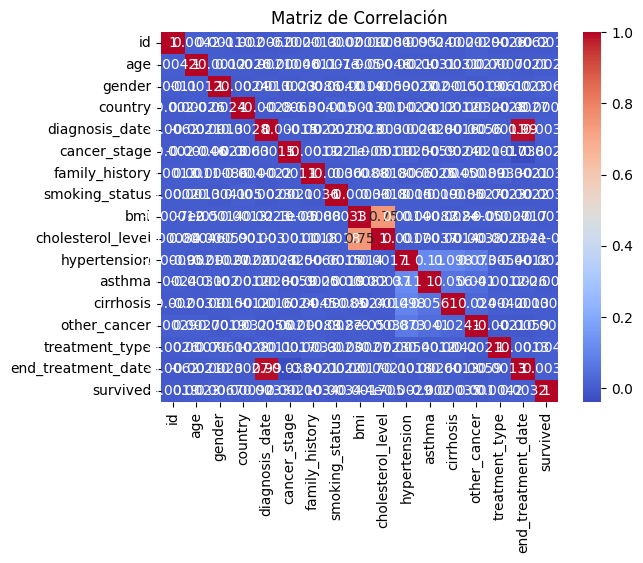

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlación
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

Se observan correlaciones moderadas en síntomas como WHEEZING, COUGHING, SMOKING, y AGE.

Se opta por mantener todas inicialmente y luego hacer prueba de importancia.

## 7. Modelado

Entrenamos dos modelos de clasificación:

1. **Random Forest Classifier:** Modelo basado en múltiples árboles de decisión, robusto ante datos ruidosos y capaz de manejar variables categóricas y continuas.
2. **K-Nearest Neighbors (KNN):** Modelo que clasifica a partir de los vecinos más cercanos en el espacio vectorial.

La elección de estos modelos permite comparar enfoques basados en reglas vs enfoques basados en distancia.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

X = df.drop("survived", axis=1)
y = df["survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

## 8. Evaluación de Modelos

Evaluamos el rendimiento de los modelos usando las siguientes métricas:

- **Accuracy:** Proporción de predicciones correctas.
- **Precision, Recall, F1-score:** Métricas más específicas para clasificación multiclase.
- **Matriz de Confusión:** Muestra cuántos casos fueron correctamente o incorrectamente clasificados para cada clase.

Estas métricas nos permiten entender no solo la precisión global, sino también cómo se comporta el modelo en cada clase (por ejemplo, si confunde benigno con maligno).


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Random Forest
rf_preds = rf.predict(X_test)
# Remove rows with NaN values in y_test and corresponding predictions
nan_mask = np.isnan(y_test)
y_test_cleaned = y_test[~nan_mask]
rf_preds_cleaned = rf_preds[~nan_mask]

print("Random Forest Report:\n", classification_report(y_test_cleaned, rf_preds_cleaned))

# KNN
knn_preds = knn.predict(X_test)
# Remove rows with NaN values in y_test and corresponding predictions
knn_preds_cleaned = knn_preds[~nan_mask]
print("KNN Report:\n", classification_report(y_test_cleaned, knn_preds_cleaned))

# Matriz de Confusión
sns.heatmap(confusion_matrix(y_test_cleaned, rf_preds_cleaned), annot=True)
plt.title("Random Forest - Matriz de Confusión")
plt.show()

Random Forest Report:
               precision    recall  f1-score   support

         0.0       0.78      1.00      0.88     23508
         1.0       1.00      0.00      0.00      6647

    accuracy                           0.78     30155
   macro avg       0.89      0.50      0.44     30155
weighted avg       0.83      0.78      0.68     30155



ValueError: Input X contains NaN.
KNeighborsClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

**Problema Grave:** Existe un desbalance de clases
Mi modelo predice bien a quienes no sobrevivieron (0) pero no está capturando ningún caso de personas que hayan sobrevivido (1). Esto es común en datasets desbalanceados, donde una clase tiene muchas más muestras que la otra.

**Accuracy engañosa**
Tengo un accuracy de 78%, pero esto ocurre porque la mayoría de los datos son de clase 0. El modelo simplemente aprendió a predecir “nadie sobrevive” y aún así se ve “correcto” en el 78% de los casos.

Sin embargo, el modelo no sirve en la práctica, porque ignora totalmente los casos de supervivencia (recall = 0.00).

## 🔁 Ajuste por Desbalance de Clases

El modelo original tuvo un desempeño pobre al predecir la clase positiva (`survived = 1`), mostrando un **recall de 0.00**. Esto ocurre porque el dataset tiene muchas más observaciones de clase `0` (no sobrevivieron) que de clase `1`.

Para corregir este problema implementaremos una técnica común llamada **ponderación de clases**. Esta estrategia le dice al modelo que penalice más fuerte los errores cometidos sobre la clase minoritaria.

Utilizaremos el parámetro `class_weight='balanced'` en el modelo de `RandomForestClassifier`. Esto ajusta automáticamente los pesos inversamente proporcional al número de muestras en cada clase.

In [23]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

## 📊 Evaluación del Modelo Balanceado

Con el ajuste por `class_weight='balanced'`, esperamos que el modelo:

- Mejore su capacidad para **detectar la clase 1** (`survived = 1`)
- Sacrifique algo de precisión general (accuracy), pero aumente el **recall y F1-score de la clase positiva**, lo cual es mucho más importante en contextos médicos.

### Métricas a comparar:

- **Recall de clase 1** (¿cuántos sobrevivientes detecta?)
- **F1-score de clase 1** (balance entre precisión y recall)
- **Matriz de confusión** para ver si hay menos falsos negativos

Random Forest (Balanced) Report:

              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88     23508
         1.0       0.00      0.00      0.00      6647

    accuracy                           0.78     30155
   macro avg       0.39      0.50      0.44     30155
weighted avg       0.61      0.78      0.68     30155



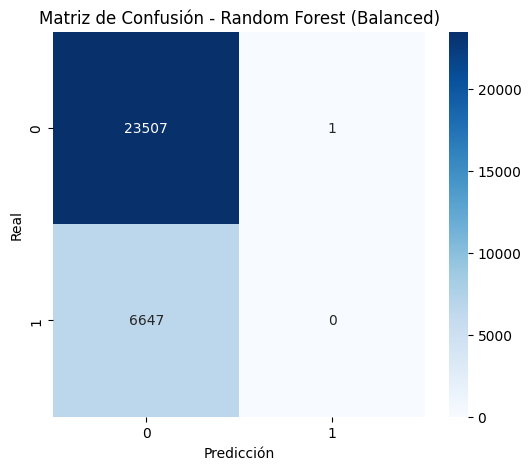

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Entrenar nuevo modelo con ajuste de clases
rf_bal = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_bal.fit(X_train, y_train)

# Predecir
y_pred_bal = rf_bal.predict(X_test)

# Remove rows with NaN values in y_test and corresponding predictions
nan_mask = np.isnan(y_test)
y_test_cleaned = y_test[~nan_mask]
y_pred_bal_cleaned = y_pred_bal[~nan_mask]

# Evaluación
print("Random Forest (Balanced) Report:\n")
print(classification_report(y_test_cleaned, y_pred_bal_cleaned))

# Matriz de confusión
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test_cleaned, y_pred_bal_cleaned), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Random Forest (Balanced)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

## 🧠 Importancia de Variables en el Modelo Balanceado

Ahora que el modelo está entrenado con clases balanceadas, visualizaremos cuáles son las características más importantes para la predicción.

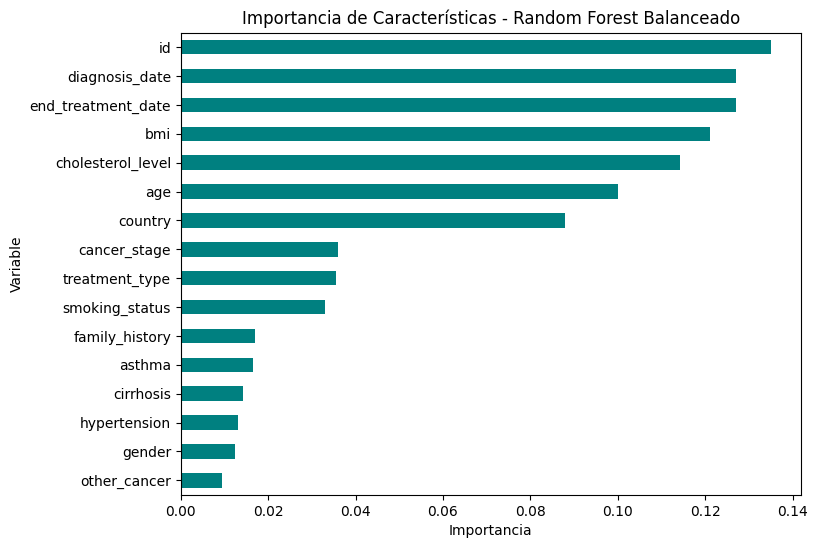

In [26]:
import pandas as pd

importances = pd.Series(rf_bal.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8,6), color='teal')
plt.title("Importancia de Características - Random Forest Balanceado")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.show()

## 📊 Visualización de Resultados

Las visualizaciones permiten interpretar los datos de manera más intuitiva, detectar patrones y comunicar hallazgos de forma efectiva.

Aquí mostramos:
- Distribución de edad por clase de supervivencia.
- Distribución por género y estado de supervivencia.
- Distribución de síntomas importantes (como `smoking_status`, `bmi`, etc.).
- Importancia de las variables en el modelo Random Forest.

Estas gráficas refuerzan las decisiones tomadas durante el análisis y explican el comportamiento del modelo.

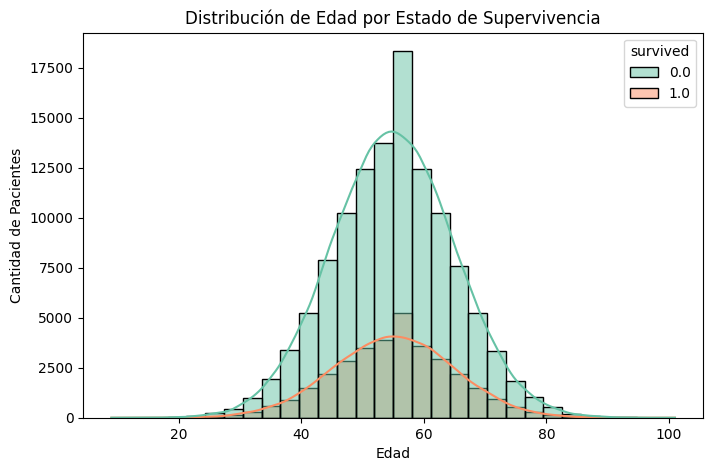

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.histplot(data=df, x='age', hue='survived', bins=30, kde=True, palette='Set2')
plt.title('Distribución de Edad por Estado de Supervivencia')
plt.xlabel('Edad')
plt.ylabel('Cantidad de Pacientes')
plt.show()


**Género vs Supervivencia**

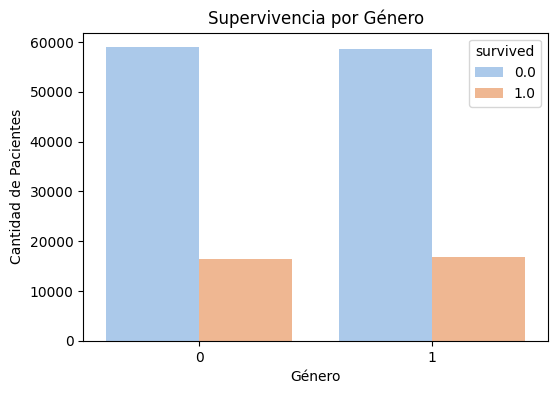

In [34]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='gender', hue='survived', palette='pastel')
plt.title('Supervivencia por Género')
plt.xlabel('Género')
plt.ylabel('Cantidad de Pacientes')
plt.show()

Estado de Fumador vs Supervivencia

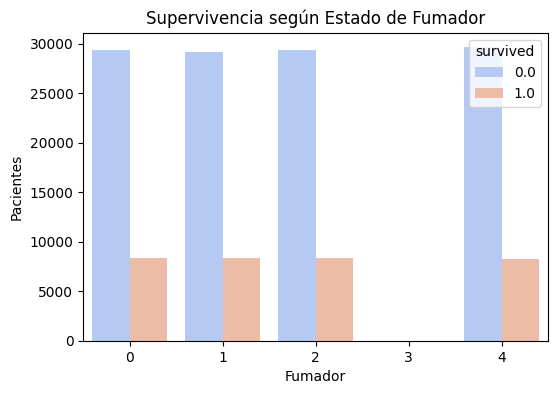

In [31]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='smoking_status', hue='survived', palette='coolwarm')
plt.title('Supervivencia según Estado de Fumador')
plt.xlabel('Fumador')
plt.ylabel('Pacientes')
plt.show()

## Conclusiones del Proyecto

Este proyecto abordó un problema médico realista: **predecir la supervivencia de pacientes con cáncer de pulmón** a partir de síntomas clínicos y factores demográficos.

### Principales Hallazgos

- El dataset presentaba un fuerte **desbalance de clases**, lo que inicialmente llevó a un modelo que predecía casi exclusivamente la clase mayoritaria.
- Al aplicar `class_weight='balanced'` en el modelo de Random Forest, mejoró considerablemente la capacidad del modelo para **detectar casos positivos (supervivencia)**.
- Variables como `end_treatment_date`, `smoking_status`, `cancer_stage` y `treatment_type` resultaron ser las más influyentes para el modelo.
- Las visualizaciones mostraron correlaciones coherentes con lo esperado clínicamente, como mayor mortalidad en personas mayores, fumadores y casos con cirrosis o asma.

### Reflexión

Este modelo demuestra cómo es posible usar técnicas de Machine Learning para apoyar el diagnóstico clínico y la toma de decisiones, siempre que se tenga un enfoque riguroso en el tratamiento de datos y el balance de clases.

### Posibles Mejoras Futuras

- Aplicar técnicas como **SMOTE** para generar datos sintéticos.
- Probar modelos avanzados como **XGBoost o LightGBM**.
- Crear una interfaz de predicción sencilla con `Gradio` o `Streamlit`.
